### Do imports

###### this is a test

In [7]:
import statistics
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pynwb import NWBFile
from pynwb import NWBHDF5IO
# from std import nwb_metric
import os
import warnings
from matplotlib import interactive

## statistical test class declaration

In [8]:
class nwb_metric:
    def __init__(self, data):

        # update references
        self.name = data.name
        data = data.data

        # clean the data of nans
        numpify = data[:]
        numpify = numpify[~np.isnan(numpify)]

        self.data = numpify

    def get_filtered_data(self):
        return self.data

    def get_data_name(self):
        return self.name

    # checks if more than 10% of data is "close" to min or max values defined as within 1% of the range
    def check_saturation(self):
        max_data = max(self.data)
        min_data = min(self.data)
        close_distance = 0.01 * (max_data - min_data)
        count = 0
        for element in self.data:
            # if abs(element-max_data) <=1:
            #     count += 1

            if (max_data - element < close_distance) or (
                element - min_data < close_distance
            ):
                count += 1

        if count / len(self.data) > 0.01:
            return "The data is highly saturated: " + str(count)
        else:
            return "The data is not highly saturated"

    def check_spread(self):
        return statistics.stdev(self.data)

    def count_jumps(self):
        min_data = min(self.data)
        max_data = max(self.data)
        jumps = 0
        for i in range(len(self.data)):
            if i < len(self.data) - 1:
                diff = abs(self.data[i] - self.data[i + 1])
                # either need to increase 0.01 or classify max_data as an outlier 
                #in order to reduce number of jumps identified
                if diff > float(0.01 * (max_data - min_data)):
                    jumps += 1
        return jumps

    def prob_jumps(self):
        num_jumps = self.count_jumps()
        if num_jumps / len(self.data) > 0.001:
            return "There are : " + str(num_jumps) + " jumps"
        elif math.ceil(num_jumps / len(self.data)):
            return "There are : " + str(num_jumps) + " jumps"
        else:
            return "There are no jumps"

### Graphing functions

In [9]:
def plot_whole_distribution(data, title, xunit, yunit):
    plt.plot(data)
    plt.xlabel(xunit)
    plt.ylabel(yunit)
    plt.title(title)
    plt.show()
    
def plot_histogram(data, title, yunit):
    plt.hist(data, bins=10)
    plt.gca().set(title= title+ ' Frequency', ylabel= 'Frequency')
    plt.show()

### Organize print statements

In [18]:
def analyze(data_container):
    for i in range(len(data_container)):
        objdata = data_container[i]
        if objdata.neurodata_type == "TimeSeries":
            print("\n")
            print("index is", i)
            checker = nwb_metric(objdata)
            data = checker.get_filtered_data()
            name = checker.get_data_name()

            print("data name: ", name)
            print("sample 10 data points: \n    ", data[:10])
            print("the data type of each data point is: ", type(data[0]))
            print("data consists of ", len(objdata.data), " data points")
            print("Standard Deviation is: \n    ", checker.check_spread())
            print("Saturation is: \n    ", checker.check_saturation())
            print("Prevalence of jumps: \n    ", checker.prob_jumps())
            print("\n")

            # plot the whole distribution
            plot_whole_distribution(data, str(name), str(objdata.timestamps_unit), str(objdata.unit))
            plot_histogram(data, str(name), str(objdata.unit))

### Ignore Warnings

In [19]:
warnings.filterwarnings("ignore")

### Read in the nwb file datasets into data_container

In [20]:
filepath='../nwb_files/test.nwb'

try:
    io = NWBHDF5IO(filepath, "r")
    nwbfile = io.read()
except:
    print("not a valid file path")


data_container = vars(nwbfile)["_AbstractContainer__children"]


#nwbfile.all_children()

# Run the Analysis!



index is 2
data name:  flow
sample 10 data points: 
     [381. 382. 379. 379. 381. 380. 379. 381. 381. 377.]
the data type of each data point is:  <class 'numpy.float64'>
data consists of  1650000  data points
Standard Deviation is: 
     22.30282348953155
Saturation is: 
     The data is not highly saturated
Prevalence of jumps: 
     There are : 337483 jumps




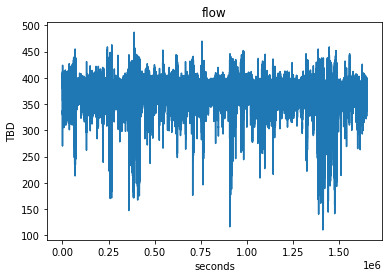

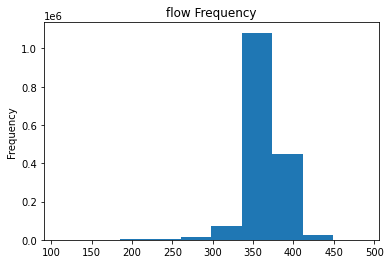



index is 3
data name:  wheel
sample 10 data points: 
     [1163. 1163. 1163. 1163. 1163. 1163. 1163. 1163. 1163. 1163.]
the data type of each data point is:  <class 'numpy.float64'>
data consists of  1650000  data points
Standard Deviation is: 
     878.44734012244
Saturation is: 
     The data is not highly saturated
Prevalence of jumps: 
     There are : 89 jumps




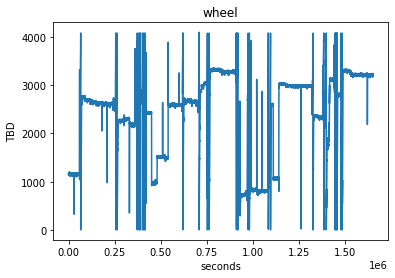

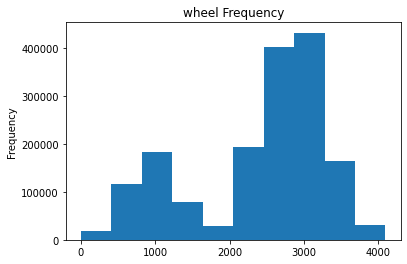



index is 4
data name:  odor
sample 10 data points: 
     [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
the data type of each data point is:  <class 'numpy.float64'>
data consists of  1650000  data points
Standard Deviation is: 
     3.1622786184347724
Saturation is: 
     The data is highly saturated: 300000
Prevalence of jumps: 
     There are : 54 jumps




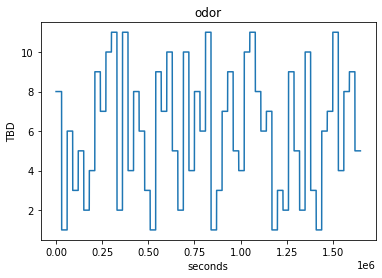

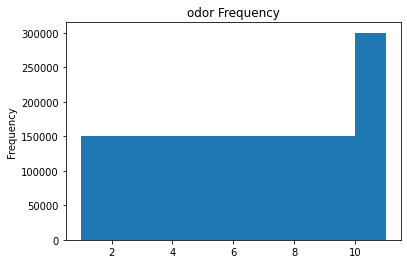

In [21]:
analyze(data_container)



# Notes from meeting

Use case is somewhat different


- change format to classes for each data that can check saturation rate with data.saturation(vars) 
-  can take in parameters to define case specific stats
- must remember to make these assessments with respect to data specific characteristics
- visualize patterns in things like saturation across broad regions of data points

ex. data.prob(fun,criterion)
give it some function to apply sample wise within a channel
criterion specifies above or below threshold

e.g.


#### check whether or not there is an equal number of positive and negative entries
data.prob(lambda x: sgn(x)>0 0.5)

timeseries/datatype aware factors that impact what constitutes "sensible" data